In [8]:

# -------------------------------
# Imports & configuration
# -------------------------------
import os, time, warnings
from pathlib import Path
import numpy as np
import pandas as pd

from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from skimage.feature import hog

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")

# Paths
DATA_CSV = "data/fer2013.csv"     # put the Kaggle CSV here
ARTIFACTS = Path("artifacts"); ARTIFACTS.mkdir(exist_ok=True)
MODELS = Path("models"); MODELS.mkdir(exist_ok=True)

# Fast defaults (tweak here if needed)
RANDOM_STATE = 42
SUBSAMPLE_PER_CLASS = 800   # keep it balanced and small; set 0 to disable undersampling
AUG_FLIP = False            # True = add a flipped copy of each TRAIN image (slower, sometimes helps)
SMOTE_STAGE = "after_pca"   # "before_pca" | "after_pca" | None
FUZZY_PCA_GRID = [12]       # keep single value for speed; try [8,12,16] if you have time
FUZZY_CLUS_GRID = [8]       # fewer clusters = faster & more stable

# For pretty printing timings
def tic(): return time.perf_counter()
def toc(t0, name):
    dt = time.perf_counter() - t0
    print(f"[{name}] {dt:.2f}s")
    return dt

# Labels
emotion_labels = {
    0: "angry", 1: "disgust", 2: "fear", 3: "happy", 4: "sad", 5: "surprise", 6: "neutral"
}
label_names = [emotion_labels[k] for k in sorted(emotion_labels.keys())]
np.random.seed(RANDOM_STATE)



## Load FER2013 CSV & Basic Stats
We use the Kaggle single‑CSV version with columns: `emotion`, `pixels`, `Usage`.


In [9]:

# Load CSV
assert Path(DATA_CSV).exists(), f"CSV not found: {DATA_CSV}. Download from Kaggle and place it here."

df = pd.read_csv(DATA_CSV)
assert set(['emotion','pixels','Usage']).issubset(df.columns), "Unexpected CSV format. Expect columns: emotion, pixels, Usage"

def parse_pixels(row):
    arr = np.fromstring(row, dtype=np.uint8, sep=' ')
    return arr.reshape(48,48)

df['img'] = df['pixels'].apply(parse_pixels)
df['label'] = df['emotion'].astype(int)

print(df['Usage'].value_counts())
print(df['emotion'].value_counts().sort_index())


Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64
0    4953
1     547
2    5121
3    8989
4    6077
5    4002
6    6198
Name: emotion, dtype: int64



## Balanced Subset (Train only) & Simple Augmentation
To keep fuzzy stable and runtime low, we train on a **balanced subset** (cap per class) and optionally **flip** training images horizontally.


In [10]:

from collections import Counter

def show_counts(name, y):
    c = Counter(y); print(name, dict(sorted(c.items())))

def balanced_subset(df_train, per_class, seed=42):
    if not per_class or per_class <= 0:
        return df_train.reset_index(drop=True)
    parts = []
    classes = sorted(df_train['emotion'].unique())
    for c in classes:
        dfc = df_train[df_train['emotion']==c]
        take = min(len(dfc), per_class)
        parts.append(dfc.sample(take, random_state=seed))
    return pd.concat(parts).reset_index(drop=True)

# Splits
df_tr_full = df[df['Usage']=="Training"].reset_index(drop=True)
df_va      = df[df['Usage']=="PublicTest"].reset_index(drop=True)
df_te      = df[df['Usage']=="PrivateTest"].reset_index(drop=True)

# Balanced small train set
df_tr = balanced_subset(df_tr_full, SUBSAMPLE_PER_CLASS)

print("Train rows (balanced cap):", len(df_tr), " Val:", len(df_va), " Test:", len(df_te))


Train rows (balanced cap): 5236  Val: 3589  Test: 3589



## HOG Features (Cached)
HOG is compact and fast, and works well at 48×48. We cache features to avoid recomputation between runs.


In [11]:

HOG_PARAMS = dict(
    orientations=9, 
    pixels_per_cell=(8,8), 
    cells_per_block=(2,2), 
    block_norm='L2-Hys', 
    transform_sqrt=True
)

def extract_hog(img48):
    if img48.ndim == 3: img48 = img48[...,0]
    imgf = img48.astype(np.float32) / 255.0
    return hog(imgf, **HOG_PARAMS)

def build_hog_features(subdf, cache_prefix, augment_flip=False):
    # Separate caches so you can switch strategies without mixing
    suffix = "_flip" if augment_flip else ""
    cache = ARTIFACTS / f"{cache_prefix}_hog_only{suffix}.npz"
    if cache.exists():
        data = np.load(cache, allow_pickle=True)
        return data["X"], data["y"]

    X_list, y_list = [], []
    for img, lab in zip(subdf['img'].values, subdf['label'].values):
        X_list.append(extract_hog(img));            y_list.append(int(lab))
        if augment_flip:
            X_list.append(extract_hog(np.fliplr(img))); y_list.append(int(lab))

    X = np.vstack(X_list).astype(np.float32)
    y = np.array(y_list, dtype=int)
    np.savez_compressed(cache, X=X, y=y)
    return X, y

# Build features (train flip optional; val/test never augmented)
t0 = tic()
X_train_raw, y_train = build_hog_features(df_tr, "train_fuzzy", augment_flip=AUG_FLIP)
toc(t0, "HOG train")
t0 = tic()
X_val_raw,   y_val   = build_hog_features(df_va, "val_fuzzy",   augment_flip=False)
X_test_raw,  y_test  = build_hog_features(df_te, "test_fuzzy",  augment_flip=False)
toc(t0, "HOG val+test")

show_counts("Train (pre-SMOTE)", y_train)
show_counts("Val", y_val)
show_counts("Test", y_test)

X_train_raw.shape, X_val_raw.shape, X_test_raw.shape


[HOG train] 0.15s
[HOG val+test] 0.17s
Train (pre-SMOTE) {0: 800, 1: 436, 2: 800, 3: 800, 4: 800, 5: 800, 6: 800}
Val {0: 467, 1: 56, 2: 496, 3: 895, 4: 653, 5: 415, 6: 607}
Test {0: 491, 1: 55, 2: 528, 3: 879, 4: 594, 5: 416, 6: 626}


((5236, 900), (3589, 900), (3589, 900))


## Cleaning & Standardisation
- **VarianceThreshold** to drop near-constant features  
- **Correlation pruning** (|r|≥0.95) to remove redundancy  
- **StandardScaler** fit on train only


In [12]:
# --- Cleaning & Standardisation (with 3σ clipping) ---
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
import numpy as np

def correlation_prune(X, threshold=0.95):
    if X.shape[1] <= 1:
        return np.ones(X.shape[1], dtype=bool)
    corr = np.corrcoef(X, rowvar=False)
    to_drop = set()
    for i in range(corr.shape[0]):
        if i in to_drop: 
            continue
        for j in range(i+1, corr.shape[1]):
            if abs(corr[i,j]) >= threshold:
                to_drop.add(j)
    keep = np.ones(corr.shape[0], dtype=bool)
    if to_drop:
        keep[list(to_drop)] = False
    return keep

t0 = tic()
var_sel = VarianceThreshold(threshold=1e-5)
Xtr_v = var_sel.fit_transform(X_train_raw)
Xva_v = var_sel.transform(X_val_raw)
Xte_v = var_sel.transform(X_test_raw)

keep_mask = correlation_prune(Xtr_v, threshold=0.95)
Xtr_c = Xtr_v[:, keep_mask]
Xva_c = Xva_v[:, keep_mask]
Xte_c = Xte_v[:, keep_mask]

scaler = StandardScaler()
Xtr_s = scaler.fit_transform(Xtr_c)
Xva_s = scaler.transform(Xva_c)
Xte_s = scaler.transform(Xte_c)

# ⬇️ CRUCIAL: clip standardised features to a bounded universe (prevents “universal set” MFs)
CLIP_STD = 3.0               # keep values within [-3σ, +3σ]
Xtr_s = np.clip(Xtr_s, -CLIP_STD, CLIP_STD)
Xva_s = np.clip(Xva_s, -CLIP_STD, CLIP_STD)
Xte_s = np.clip(Xte_s, -CLIP_STD, CLIP_STD)

toc(t0, "Clean + Standardise + Clip")
Xtr_s.shape, Xva_s.shape, Xte_s.shape


[Clean + Standardise + Clip] 0.49s


((5236, 828), (3589, 828), (3589, 828))


## Fuzzy TSK (pyFUME) with Conservative Simplification
pyFUME sometimes **over-simplifies** membership functions on whitened PCA signals.  
We **relax** simplification so fuzzy sets are not removed aggressively.


In [13]:
# --- Fuzzy TSK (pyFUME) with conservative/disabled simplification ---
class FuzzyTSKClassifier:
    def __init__(self, nr_clusters=6, process_categorical=False,
                 merge_threshold=1.0, remove_flat_threshold=1.01, setnes_threshold=1.0,
                 model_order="zero", random_state=42):
        self.nr_clusters = nr_clusters
        self.process_categorical = process_categorical
        self.merge_threshold = merge_threshold
        self.remove_flat_threshold = remove_flat_threshold
        self.setnes_threshold = setnes_threshold
        self.model_order = model_order
        self.random_state = random_state
        self._pyf = None
        self._model = None

    def fit(self, X, y):
        try:
            from pyfume.pyfume import pyFUME as PyFUMEBuilder
        except Exception as e:
            raise ImportError("pyFUME not available. Use numpy==1.24.4, pyfume, simpful.") from e
        import pandas as pd
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=int)
        feat_names = [f"x{i+1}" for i in range(X.shape[1])]
        df = pd.DataFrame(X, columns=feat_names)
        df["OUTPUT"] = y
        # Pass conservative thresholds + zero-order model
        self._pyf = PyFUMEBuilder(
            dataframe=df,
            nr_clus=self.nr_clusters,
            process_categorical=self.process_categorical,
            merge_threshold=self.merge_threshold,
            remove_flat_threshold=self.remove_flat_threshold,
            setnes_threshold=self.setnes_threshold,
            model_order=self.model_order,                 # ⬅️ zero-order
            variable_names=feat_names + ["OUTPUT"],
        )
        self._model = self._pyf.get_model()
        return self

    def predict(self, X):
        X = np.asarray(X, dtype=float)
        return np.asarray(self._pyf.predict_label(X), dtype=int)



## Train & Evaluate (fast defaults)
- Single PCA dim (12) and cluster count (8) → fast.  
- **SMOTE** applied **after PCA** by default (keeps PCA fit on real data).  
- Prints timing and metrics; saves the PKL bundle.


In [15]:
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

# Fast & robust defaults
FUZZY_PCA_GRID = [8]     # smaller dims → tighter sets
FUZZY_CLUS_GRID = [6]    # fewer clusters → faster, stabler
SMOTE_STAGE = "before_pca"   # safer for pyFUME than after_pca

best_combo = None
best_val_f1 = -1.0
best_bundle = None

def try_fit_once(p, k, smote_stage):
    # Build PCA (no whitening — avoids overly wide MFs)
    pca_f = PCA(n_components=p, svd_solver="randomized", whiten=False, random_state=RANDOM_STATE)

    if smote_stage == "before_pca":
        sm = SMOTE(random_state=RANDOM_STATE)
        Xtr_smote_pre, ytr_smote_pre = sm.fit_resample(Xtr_s, y_train) # (N_smote, 828)
        
        # Fit PCA on SMOTEd data
        Xtr_processed = pca_f.fit_transform(Xtr_smote_pre) # (N_smote, p)
        ytr_processed = ytr_smote_pre
        
        # Transform val/test using the same PCA
        Xva_p = pca_f.transform(Xva_s)
        Xte_p = pca_f.transform(Xte_s)
        
    elif smote_stage == "after_pca":
        # Fit PCA on *original* train data
        Xtr_p = pca_f.fit_transform(Xtr_s) # (N_orig, p)
        Xva_p = pca_f.transform(Xva_s)
        Xte_p = pca_f.transform(Xte_s)
        
        # SMOTE *after* PCA
        sm = SMOTE(random_state=RANDOM_STATE)
        Xtr_processed, ytr_processed = sm.fit_resample(Xtr_p, y_train) # (N_smote, p)
    
    else: # No SMOTE
        # Fit PCA on *original* train data
        Xtr_processed = pca_f.fit_transform(Xtr_s) # (N_orig, p)
        ytr_processed = y_train
        Xva_p = pca_f.transform(Xva_s)
        Xte_p = pca_f.transform(Xte_s)

    # --- THIS IS THE FIX ---
    # Now, fit on the correct processed data (which always has 'p' dimensions)
    clf = FuzzyTSKClassifier(nr_clusters=k)
    clf.fit(Xtr_processed, ytr_processed) 
    
    # Predict on the transformed val/test sets
    yv = clf.predict(Xva_p)
    yt = clf.predict(Xte_p)
    return pca_f, clf, Xva_p, Xte_p, yv, yt

# Try primary config; if pyFUME still complains, try safer fallbacks automatically
TRIALS = [
    dict(p=8, k=6, sm="before_pca"),
    dict(p=8, k=4, sm="before_pca"),
    dict(p=6, k=4, sm="before_pca"),
    dict(p=8, k=4, sm=None),
]

for trial in TRIALS:
    p, k, sm = trial["p"], trial["k"], trial["sm"]
    t1 = tic()
    try:
        pca_f, clf, Xva_p, Xte_p, yv, yt = try_fit_once(p, k, sm)
        acc_v = accuracy_score(y_val, yv)
        f1m   = f1_score(y_val, yv, average='macro')
        bacc  = balanced_accuracy_score(y_val, yv)
        toc(t1, f"PCA/SMOTE/fit/predict (p={p}, k={k}, smote={sm})")
        print(f"[Fuzzy] p={p}, k={k}, smote={sm} → Val Acc={acc_v:.4f} BalAcc={bacc:.4f} Macro-F1={f1m:.4f}")
        best_combo = (p, k, sm)
        best_val_f1 = f1m
        best_bundle = dict(pca=pca_f, clf=clf, Xva=Xva_p, Xte=Xte_p, yv=yv, yt=yt)
        break
    except Exception as e:
        print(f"[WARN] Trial failed (p={p}, k={k}, smote={sm}): {e}")

if best_bundle is None:
    raise RuntimeError("All fuzzy trials failed. Try reducing SUBSAMPLE_PER_CLASS or check pyFUME install.")

print("\\nChosen config:", best_combo, "Val Macro-F1:", best_val_f1)


 * Detected 0 categorical variables.
['x1' 'x2' 'x3' 'x4' 'x5' 'x6' 'x7' 'x8']
[PCA/SMOTE/fit/predict (p=8, k=6, smote=before_pca)] 45.96s
[Fuzzy] p=8, k=6, smote=before_pca → Val Acc=0.2494 BalAcc=0.1429 Macro-F1=0.0570
\nChosen config: (8, 6, 'before_pca') Val Macro-F1: 0.05702816362941251



## Final Metrics & Confusion Matrices


=== Fuzzy TSK — PublicTest ===
Acc=0.2494  BalAcc=0.1429  Macro-F1=0.0570
              precision    recall  f1-score   support

       angry       0.00      0.00      0.00       467
     disgust       0.00      0.00      0.00        56
        fear       0.00      0.00      0.00       496
       happy       0.25      1.00      0.40       895
         sad       0.00      0.00      0.00       653
    surprise       0.00      0.00      0.00       415
     neutral       0.00      0.00      0.00       607

    accuracy                           0.25      3589
   macro avg       0.04      0.14      0.06      3589
weighted avg       0.06      0.25      0.10      3589

=== Fuzzy TSK — PrivateTest ===
Acc=0.2449  BalAcc=0.1429  Macro-F1=0.0562
              precision    recall  f1-score   support

       angry       0.00      0.00      0.00       491
     disgust       0.00      0.00      0.00        55
        fear       0.00      0.00      0.00       528
       happy       0.24      1.00    

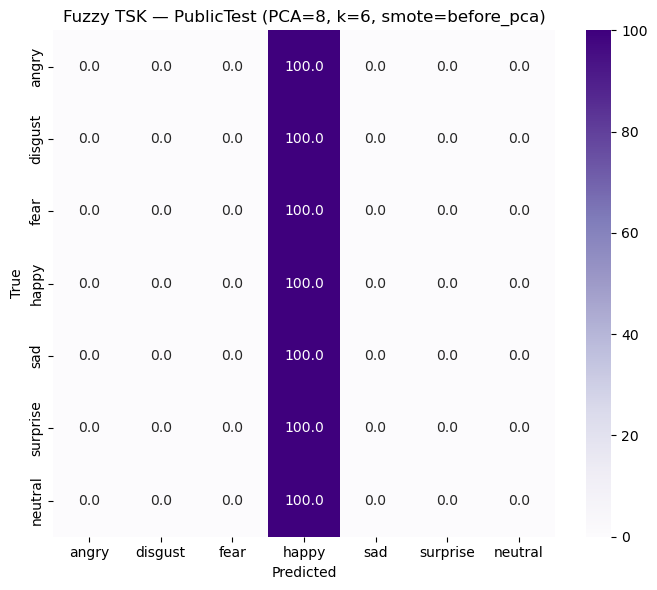

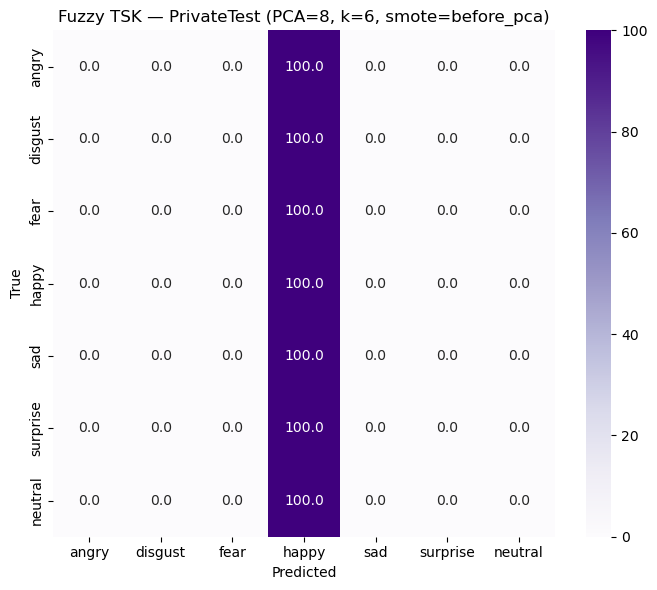

In [17]:
p_best, k_best, sm_best = best_combo
pca_f = best_bundle['pca']
clf_f = best_bundle['clf']
Xva_p = best_bundle['Xva']
Xte_p = best_bundle['Xte']
yv = best_bundle['yv']
yt = best_bundle['yt']

val_acc  = accuracy_score(y_val, yv)
val_bacc = balanced_accuracy_score(y_val, yv)
val_f1   = f1_score(y_val, yv, average='macro')

te_acc  = accuracy_score(y_test, yt)
te_bacc = balanced_accuracy_score(y_test, yt)
te_f1   = f1_score(y_test, yt, average='macro')

print("=== Fuzzy TSK — PublicTest ===")
print(f"Acc={val_acc:.4f}  BalAcc={val_bacc:.4f}  Macro-F1={val_f1:.4f}")
print(classification_report(y_val, yv, target_names=label_names))

print("=== Fuzzy TSK — PrivateTest ===")
print(f"Acc={te_acc:.4f}  BalAcc={te_bacc:.4f}  Macro-F1={te_f1:.4f}")
print(classification_report(y_test, yt, target_names=label_names))

def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=sorted(emotion_labels.keys()), normalize='true') * 100
    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt=".1f", cmap="Purples",
                xticklabels=label_names, yticklabels=label_names)
    plt.title(title); plt.xlabel("Predicted"); plt.ylabel("True"); plt.tight_layout(); plt.show()

plot_cm(y_val, yv,  f"Fuzzy TSK — PublicTest (PCA={p_best}, k={k_best}, smote={sm_best})")
plot_cm(y_test, yt, f"Fuzzy TSK — PrivateTest (PCA={p_best}, k={k_best}, smote={sm_best})")



## Save PKL (for the demo)
Writes `models/fuzzy_tsfis.pkl` containing scaler, PCA, fuzzy model, labels.


In [18]:

import joblib
bundle = {
    "scaler": scaler,
    "pca": pca_f,
    "fuzzy": clf_f,
    "pca_dims": p_best,
    "nr_clusters": k_best,
    "labels": emotion_labels
}
out_path = MODELS / "fuzzy_tsfis.pkl"
joblib.dump(bundle, out_path)
print("Saved:", out_path)


Saved: models\fuzzy_tsfis.pkl
